In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
import tensorflow as tf
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score

# Chapter 1
* Data Load
* Preprosesing
* Make Data Train Balanced
* Create Image Data Generator

## Load The Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("benjaminwarner/resized-2015-2019-blindness-detection-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'resized-2015-2019-blindness-detection-images' dataset.
Path to dataset files: /kaggle/input/resized-2015-2019-blindness-detection-images


In [3]:
os.listdir(path)

['labels',
 'resized test 15',
 'resized train 19',
 'resized train 15',
 'resized test 19']

In [4]:

os.listdir(path+"/labels")

['trainLabels19.csv',
 'testImages19.csv',
 'trainLabels15.csv',
 'testLabels15.csv']

In [5]:
train_df_19=pd.read_csv(path+"/labels/trainLabels19.csv")
train_df_15=pd.read_csv(path+"/labels/trainLabels15.csv")

In [6]:
train_df_15.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


<Axes: xlabel='level', ylabel='count'>

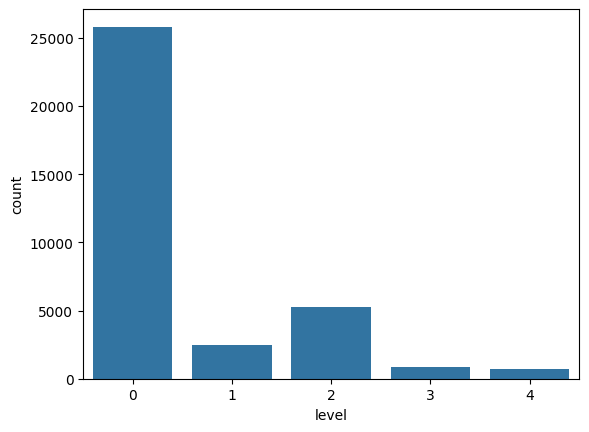

In [7]:
sns.countplot(data=train_df_15,x='level')

In [8]:
train_df_19.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: xlabel='diagnosis', ylabel='count'>

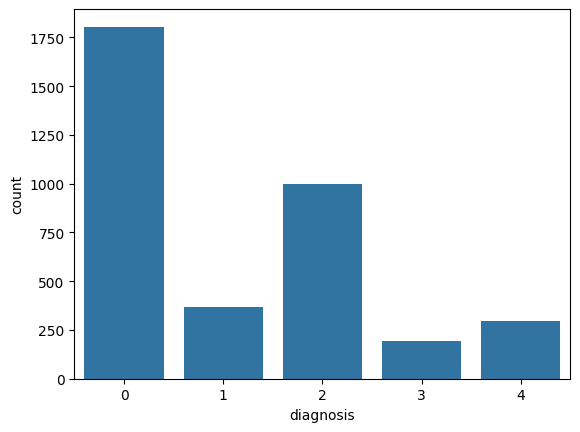

In [9]:
sns.countplot(data=train_df_19,x='diagnosis')

## Combine The Two Datasets

In [10]:
train_df_15.rename(columns={'image':'id_code','level':'diagnosis'},inplace=True)


In [11]:
train_df_15_0=train_df_15[train_df_15['diagnosis']==0]
train_df_15_0=train_df_15_0.sample(n=5000,random_state=0)

In [12]:
train_df_15_other=train_df_15[train_df_15['diagnosis']!=0]

In [13]:
train_df_15=pd.concat([train_df_15_0,train_df_15_other],ignore_index=True)

<Axes: xlabel='diagnosis', ylabel='count'>

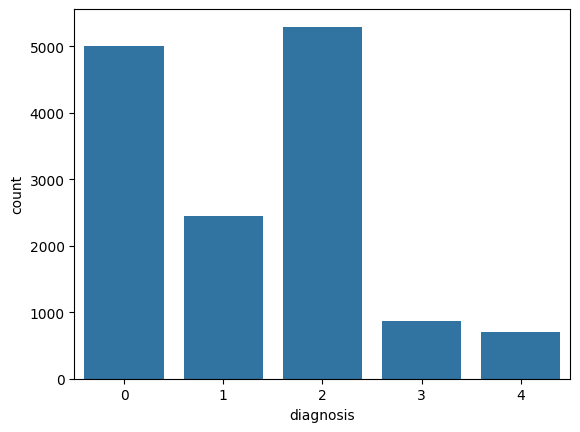

In [14]:
sns.countplot(data=train_df_15,x='diagnosis')

In [15]:

train_df_15['image_folder'] = os.path.join(path, "resized train 15")


In [16]:
train_df_19['image_folder'] = os.path.join(path, "resized train 19")
train_df=pd.concat([train_df_15,train_df_19], ignore_index=True)

<Axes: xlabel='diagnosis', ylabel='count'>

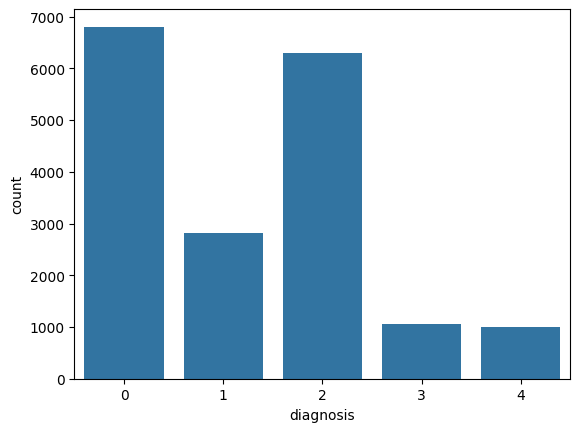

In [17]:
sns.countplot(data=train_df,x='diagnosis')

In [18]:
train_df.head()

,id_code,diagnosis,image_folder
0,40576_left,0,/kaggle/input/resized-2015-2019-blindness-dete...
1,33112_left,0,/kaggle/input/resized-2015-2019-blindness-dete...
2,31961_right,0,/kaggle/input/resized-2015-2019-blindness-dete...
3,2515_left,0,/kaggle/input/resized-2015-2019-blindness-dete...
4,40364_right,0,/kaggle/input/resized-2015-2019-blindness-dete...


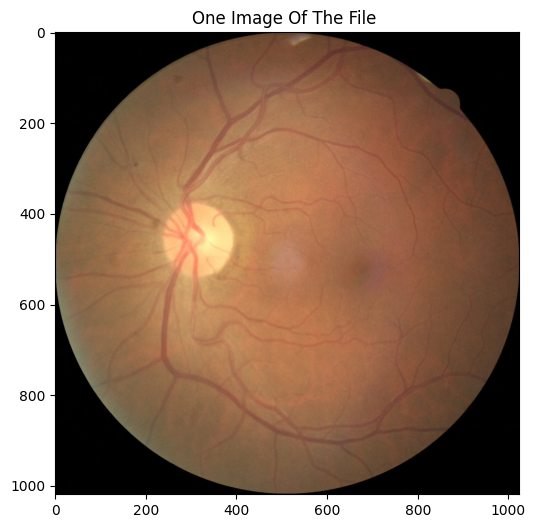

In [19]:
plt.figure(figsize=(10, 6))
plt.title('One Image Of The File ')

image_dir = train_df['image_folder'][0]
image_filename = os.listdir(image_dir)[0]
full_image_path = os.path.join(image_dir, image_filename)

image_data = plt.imread(full_image_path)
plt.imshow(image_data)

In [20]:
total_images=len(train_df)
print(f"Total Images: {total_images}")

Total Images: 17978


## Plot Some Images

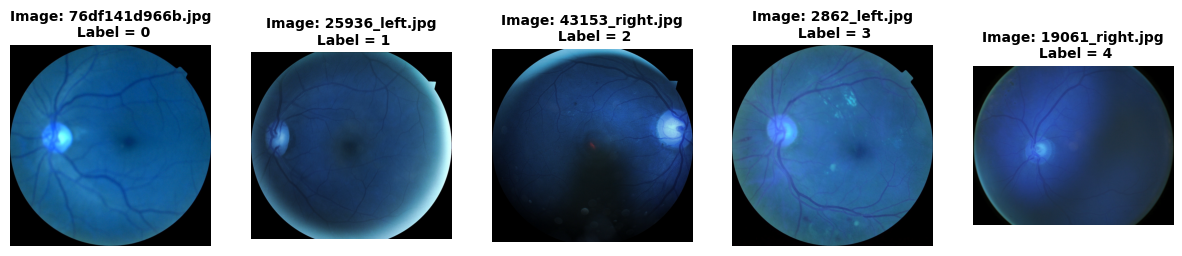

In [21]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()

    image_path = os.path.join(sample['image_folder'].item(), f"{image_name}.jpg")

    X = cv2.imread(image_path)

    if X is None:
        print(f"Warning: Could not read image at {image_path}. Skipping plot for this sample.")
        continue
    ax[i].set_title(f"Image: {image_name}.jpg\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Make Semi-Balanced Train Dataset

In [22]:
IM_SIZE = 524
print(f"IM_SIZE defined as: {IM_SIZE}")

IM_SIZE defined as: 524


In [23]:
def create_augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.8, fill_mode="constant"),  # ~15 degrees
            tf.keras.layers.RandomZoom(0.2),
        ]
    )

In [24]:
def create_balanced_dataset(train_df, output_dir, target_total_per_class, min_images_per_class, augmentation_function, im_size):
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    balanced_data = []
    unique_diagnoses = sorted(train_df['diagnosis'].unique())

    for diagnosis_level in unique_diagnoses:
        class_df = train_df[train_df['diagnosis'] == diagnosis_level]
        current_count = len(class_df)
        print(f"Processing diagnosis level {diagnosis_level}: Current count = {current_count}")

        # Determine the target count for this class
        target_count = max(target_total_per_class.get(diagnosis_level, 0), min_images_per_class)
        print(f"Target count for diagnosis level {diagnosis_level} = {target_count}")

        # Copy original images to the new directory
        for index, row in class_df.iterrows():
            original_image_path = os.path.join(row['image_folder'], f"{row['id_code']}.jpg")
            new_image_filename = f"{row['id_code']}.jpg"
            new_image_path = os.path.join(output_dir, new_image_filename)

            # Read and resize image before saving
            img = cv2.imread(original_image_path)
            if img is None:
                print(f"Warning: Could not read image {original_image_path}. Skipping.")
                continue
            img = cv2.resize(img, (im_size, im_size))
            cv2.imwrite(new_image_path, img)
            balanced_data.append({'id_code': row['id_code'], 'diagnosis': diagnosis_level, 'relative_path': new_image_filename})

        # Augment images if necessary
        num_to_augment = target_count - current_count
        if num_to_augment > 0:
            print(f"Augmenting {num_to_augment} images for diagnosis level {diagnosis_level}")
            # Get paths to the images that will be augmented
            # We use a random sample of existing images for augmentation
            images_for_augmentation = class_df.sample(n=min(current_count, num_to_augment), replace=True)

            for i in range(num_to_augment):
                # Select an image to augment (randomly if num_to_augment > current_count)
                sample_row = images_for_augmentation.sample(1).iloc[0]
                original_image_path = os.path.join(sample_row['image_folder'], f"{sample_row['id_code']}.jpg")

                img = cv2.imread(original_image_path)
                if img is None:
                    print(f"Warning: Could not read image {original_image_path} for augmentation. Skipping.")
                    continue

                # Resize before augmentation for consistent input size
                img = cv2.resize(img, (im_size, im_size))
                # Convert to TF Tensor, apply augmentation, convert back to numpy
                augmented_img_tf = augmentation_function(tf.expand_dims(tf.convert_to_tensor(img), 0))
                augmented_img_np = augmented_img_tf[0].numpy().astype(np.uint8)

                new_image_filename = f"{sample_row['id_code']}_aug_{i}.jpg"
                new_image_path = os.path.join(output_dir, new_image_filename)
                cv2.imwrite(new_image_path, augmented_img_np)
                balanced_data.append({'id_code': f"{sample_row['id_code']}_aug_{i}", 'diagnosis': diagnosis_level, 'relative_path': new_image_filename})

    return pd.DataFrame(balanced_data)

print("create_balanced_dataset function defined.")

create_balanced_dataset function defined.


In [25]:
output_dir = 'balanced_train_dataset'

# Get current class counts to inform target counts
class_counts = train_df['diagnosis'].value_counts().sort_index()
print(f"Original class counts:\n{class_counts}")

# Define target counts: augment minority classes up to a minimum, keep majority classes as is
min_images_per_class = 4000 # Example minimum, can be adjusted
target_total_per_class = {}
for diagnosis_level in sorted(train_df['diagnosis'].unique()):
    current_count = class_counts.get(diagnosis_level, 0)
    if current_count < min_images_per_class:
        target_total_per_class[diagnosis_level] = min_images_per_class
    else:
        target_total_per_class[diagnosis_level] = current_count

print(f"Target images per class:\n{target_total_per_class}")

# Create the augmentation layer instance
augmentation_layer = create_augmentation_layer()

# Call the function to create the balanced dataset
balanced_train_df = create_balanced_dataset(train_df,
                                            output_dir,
                                            target_total_per_class,
                                            min_images_per_class,
                                            augmentation_layer,
                                            IM_SIZE)

print("Balanced dataset created.")

Original class counts:
diagnosis
0    6805
1    2813
2    6291
3    1066
4    1003
Name: count, dtype: int64
Target images per class:
{np.int64(0): np.int64(6805), np.int64(1): 4000, np.int64(2): np.int64(6291), np.int64(3): 4000, np.int64(4): 4000}
Processing diagnosis level 0: Current count = 6805
Target count for diagnosis level 0 = 6805
Processing diagnosis level 1: Current count = 2813
Target count for diagnosis level 1 = 4000
Augmenting 1187 images for diagnosis level 1
Processing diagnosis level 2: Current count = 6291
Target count for diagnosis level 2 = 6291
Processing diagnosis level 3: Current count = 1066
Target count for diagnosis level 3 = 4000
Augmenting 2934 images for diagnosis level 3
Processing diagnosis level 4: Current count = 1003
Target count for diagnosis level 4 = 4000
Augmenting 2997 images for diagnosis level 4
Balanced dataset created.


<Axes: xlabel='diagnosis', ylabel='count'>

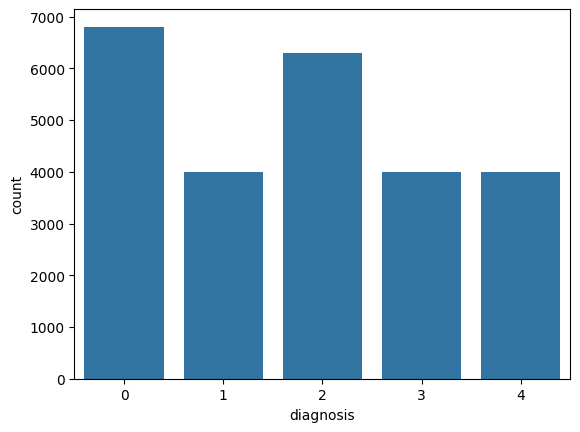

In [26]:
sns.countplot(data=balanced_train_df,x='diagnosis')

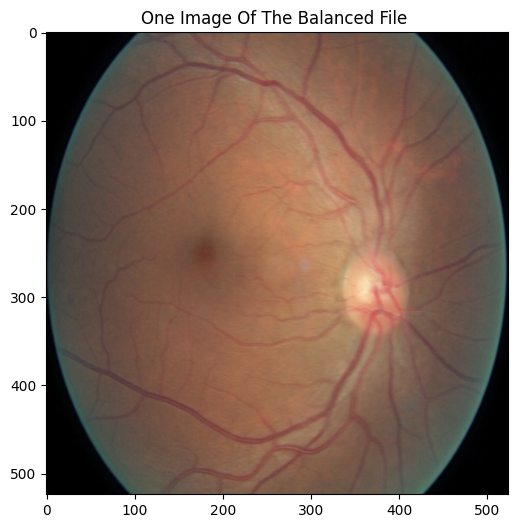

In [27]:
plt.figure(figsize=(10, 6))
plt.title('One Image Of The Balanced File ')

full_image_path = os.path.join(output_dir, balanced_train_df['relative_path'][0])

image_data = plt.imread(full_image_path)
plt.imshow(image_data)

In [28]:
balanced_train_df['full_path'] = balanced_train_df['relative_path'].apply(lambda x: os.path.join(output_dir, x))

display(balanced_train_df.head())

,id_code,diagnosis,relative_path,full_path
0,40576_left,0,40576_left.jpg,balanced_train_dataset/40576_left.jpg
1,33112_left,0,33112_left.jpg,balanced_train_dataset/33112_left.jpg
2,31961_right,0,31961_right.jpg,balanced_train_dataset/31961_right.jpg
3,2515_left,0,2515_left.jpg,balanced_train_dataset/2515_left.jpg
4,40364_right,0,40364_right.jpg,balanced_train_dataset/40364_right.jpg


## Make The Validation Set

In [29]:
os.listdir(path+"/labels")

['trainLabels19.csv',
 'testImages19.csv',
 'trainLabels15.csv',
 'testLabels15.csv']

In [30]:

test_df_15=pd.read_csv(path+"/labels/testLabels15.csv")

In [31]:
test_df_15.drop(columns=['Usage'],inplace=True)
test_df_15.head()

,image,level
0,1_left,0
1,1_right,0
2,2_left,0
3,2_right,0
4,3_left,2


<Axes: xlabel='level', ylabel='count'>

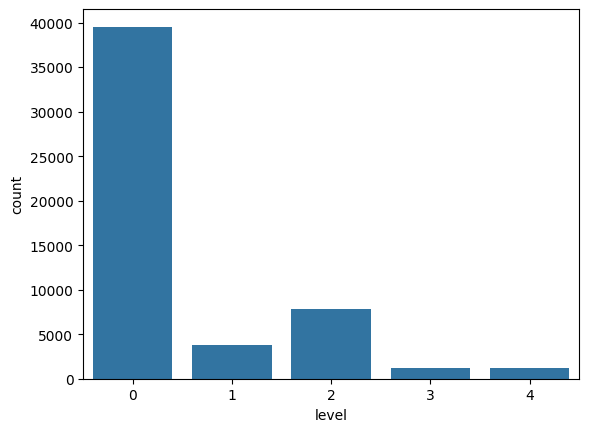

In [32]:
sns.countplot(data=test_df_15,x='level')

In [33]:
sampled_dfs = []
# Assuming diagnosis levels are 0-4 based on previous countplots
for i in range(5):
    class_df = test_df_15[test_df_15['level'] == i]
    n_samples = min(500, len(class_df))
    if n_samples > 0:
        sample = class_df.sample(n=n_samples, random_state=0)
        sampled_dfs.append(sample)
    else:
        print(f"Warning: No samples found for level {i} in test_df_15.")

if sampled_dfs:
    test_df_15 = pd.concat(sampled_dfs, ignore_index=True)
    print(f"Validation dataset created with {len(test_df_15)} samples.")
else:
    print("No samples were collected. test_df_15 remains unchanged or becomes empty.")


Validation dataset created with 2500 samples.


In [34]:
test_df_15['level'].value_counts()

,count
level,
0,500
1,500
2,500
3,500
4,500


In [35]:
test_images_dir = os.path.join(path, "resized test 15")

In [36]:
test_df_15['full_path'] = test_df_15['image'].apply(lambda x: os.path.join(test_images_dir, x+'.jpg'))

In [37]:
test_df_15['full_path'][0]

'/kaggle/input/resized-2015-2019-blindness-detection-images/resized test 15/43788_left.jpg'

## Resize+CLAHE

In [38]:
import cv2
import numpy as np

def apply_clahe(image):

    if image.dtype != np.uint8:

        if image.max() <= 1.0 and image.min() >= 0.0:
            image = (image * 255).astype(np.uint8)
        else:

            image = image.astype(np.uint8)


    if len(image.shape) == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        l_channel, a_channel, b_channel = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a_channel, b_channel))

        enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    elif len(image.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or 3-channel color.")

    return enhanced_image

In [39]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(IM_SIZE,IM_SIZE))
  image=image/255.0
  return apply_clahe(image)

* The Images That The Models Will See

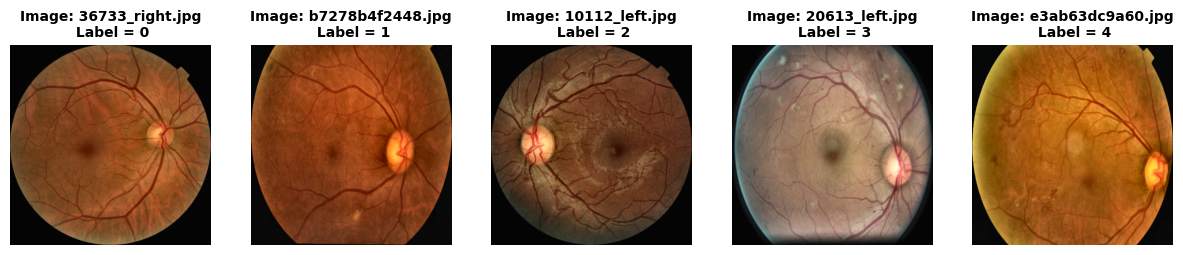

In [40]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()

    image_path = os.path.join(sample['image_folder'].item(), f"{image_name}.jpg")

    X = cv2.imread(image_path)
    X=image_resize(X)

    if X is None:
        print(f"Warning: Could not read image at {image_path}. Skipping plot for this sample.")
        continue
    ax[i].set_title(f"Image: {image_name}.jpg\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Create ImageDataGenerator

In [41]:
len_bal=len(balanced_train_df)
len_val=len(test_df_15)
print(f"Len Bal: {len_bal}")
print(f"Len Val: {len_val}")

Len Bal: 25096
Len Val: 2500


In [42]:
from numpy.random import shuffle
train_datagen = ImageDataGenerator(preprocessing_function=image_resize)

val_gen=ImageDataGenerator(preprocessing_function=image_resize)


train_gen = train_datagen.flow_from_dataframe(balanced_train_df,
                                                    x_col='full_path',
                                                    y_col='diagnosis',
                                                    directory = None,
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    shuffle=True)


val_gen = train_datagen.flow_from_dataframe(test_df_15,
                                                  x_col='full_path',
                                                  y_col='level',
                                                  directory = None,
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=32,
                                                  class_mode='raw')

Found 25096 validated image filenames.
Found 2500 validated image filenames.


## The QWKMetric

In [43]:
class QWKRegressionCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, model_name='best_model.keras'):
        super(QWKRegressionCallback, self).__init__()
        self.validation_data = validation_data
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.best_kappa = -1
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs={}):
        # 1. Get continuous predictions (e.g., 2.4, 3.1)
        y_pred_continuous = self.model.predict(self.x_val, verbose=0)

        # 2. Round and Clip:
        # - Round to nearest integer
        # - Clip to ensure we don't return -1 or 5
        y_pred_discrete = np.rint(y_pred_continuous).astype(int)
        y_pred_discrete = np.clip(y_pred_discrete, 0, 4)

        # 3. Handle y_val (ensure it is also flattened integers)
        y_true = self.y_val
        if len(y_true.shape) > 1:
            y_true = np.argmax(y_true, axis=1) # Handle if one-hot encoded

        # 4. Calculate Score
        val_kappa = cohen_kappa_score(y_true, y_pred_discrete, weights='quadratic')

        print(f" — val_qwk: {val_kappa:.4f}")

        # 5. Save if best
        if val_kappa > self.best_kappa:
            self.best_kappa = val_kappa
            self.model.save(self.model_name)
            print(f"    Saved new best model with QWK: {val_kappa:.4f}")

# Chapter 2 (The Models)
* VGG16 Regression Run
* EfficientNetB0
* InceptionV3 Regression Run
* InceptionV4 Regression Run
* ViT Regression Run
*

## VGG16

In [44]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


* For Attention

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = tf.keras.layers.GlobalAveragePooling2D()(x)

attention_probs = tf.keras.layers.Dense(64, activation='relu')(ap)

attention_probs = tf.keras.layers.Dense(512, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 512))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = tf.keras.layers.GlobalAveragePooling2D()(attended_output)

x = tf.keras.layers.Dense(256, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='linear')(x)


In [51]:
def lr_schedule_exp(epoch):
  if epoch<7:
    return float(tf.exp(-epoch/10.)*0.01)/2
  elif epoch<15:
    return float(tf.exp(-epoch/10.)*0.01)/3
  else:
    return float(tf.exp(-epoch/10.)*0.01)/4

schedule_1=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)

In [52]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='VGG_REG_TOP.keras',monitor='val_loss',save_best_only=True)
early_stop_it=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,mode='min')

In [53]:
model=tf.keras.Model(inputs=base_model.input,outputs=output_layer)

In [54]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', metrics=['mae'] )
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 524, 524,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 524, 524,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 524, 524,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 262, 262,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 262, 262,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 262, 262,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 131, 131,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 131, 131,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 131, 131,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 131, 131,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 65, 65,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 65, 65,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 65, 65,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 65, 65,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 32, 32,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 32, 32,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 32, 32,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,912,385 (56.89 MB)

 Trainable params: 197,697 (772.25 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
model.fit(train_gen,validation_data=val_gen,epochs=30,callbacks=[model_checkpoint_callback,early_stop_it,schedule_1,QWKRegressionCallback()])

Epoch 1/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 804s 1s/step - loss: 1.0309 - mae: 0.8214 - val_loss: 1.4416 - val_mae: 0.9860 - learning_rate: 0.0050
Epoch 2/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 798s 1s/step - loss: 0.8028 - mae: 0.7246 - val_loss: 1.0568 - val_mae: 0.8222 - learning_rate: 0.0045
Epoch 3/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 800s 1s/step - loss: 0.7509 - mae: 0.6960 - val_loss: 1.2610 - val_mae: 0.9165 - learning_rate: 0.0041
Epoch 4/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 801s 1s/step - loss: 0.7269 - mae: 0.6828 - val_loss: 1.2162 - val_mae: 0.8674 - learning_rate: 0.0037
Epoch 5/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 798s 1s/step - loss: 0.7002 - mae: 0.6688 - val_loss: 1.3117 - val_mae: 0.9246 - learning_rate: 0.0034
Epoch 6/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 799s 1s/step - loss: 0.6732 - mae: 0.6533 - val_loss: 1.3460 - val_mae: 0.9393 - learning_rate: 0.0030


In [ ]:
model = tf.keras.models.load_model('/content/VGG_REG_TOP (4).keras')
model.compile(optimizer=tf.keras.optimizers.Nadam(1e-3), loss='mse', metrics=['mae'] )

### Continue Training the Loaded Model

In [ ]:

model.fit(train_gen,
          validation_data=val_gen,
          epochs=30,
          callbacks=[model_checkpoint_callback, early_stop_it],initial_epoch=14)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 15/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 1046s 1s/step - loss: 0.6179 - mae: 0.6302 - val_loss: 1.1796 - val_mae: 0.8786
Epoch 16/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 953s 1s/step - loss: 0.6116 - mae: 0.6273 - val_loss: 1.1698 - val_mae: 0.8743
Epoch 17/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - loss: 0.6020 - mae: 0.6212 - val_loss: 1.1869 - val_mae: 0.8808
Epoch 18/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - loss: 0.6018 - mae: 0.6232 - val_loss: 1.1874 - val_mae: 0.8804
Epoch 19/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 951s 1s/step - loss: 0.5986 - mae: 0.6191 - val_loss: 1.1983 - val_mae: 0.8844
Epoch 20/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - loss: 0.5944 - mae: 0.6149 - val_loss: 1.1828 - val_mae: 0.8786
